In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import Fixed_QSDE, QSDE
from sdebridge.utils import *

plt.style.use('ggplot')

In [3]:
d = 16
alpha = 1.0
sigma = 0.5

rng = jax.random.PRNGKey(0)

### Fixed Q

In [4]:
circle1 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
init_Q = eval_Q(circle1, alpha, sigma)
print(init_Q.shape)

sde_params = {
    "dimension": d,
    "num_steps": 100,
    "init_Q": init_Q
}
sde = Fixed_QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = circle1
XT = sample_circle(num_points=d//2, scale=1.3, shifts=jnp.array([0.0, 0.0]))

(16, 16)


(1, 100, 16)


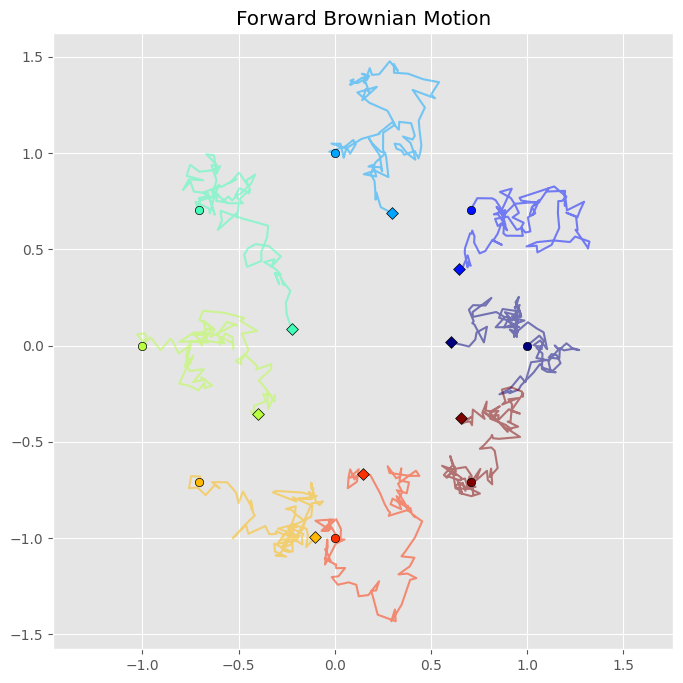

In [5]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=jax.random.PRNGKey(0),
    num_batches=1
)
print(forward_brownian_motion["trajectories"].shape)
plot_single_trajectory(forward_brownian_motion["trajectories"][0], title="Forward Brownian Motion")

In [9]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 256,
                "encoding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 128, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 40,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng,
                                     loss_calibration=False)

Training: 100%|██████████| 40/40 [01:15<00:00,  1.88s/epoch, Epoch=40, loss=7.6894]


In [10]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

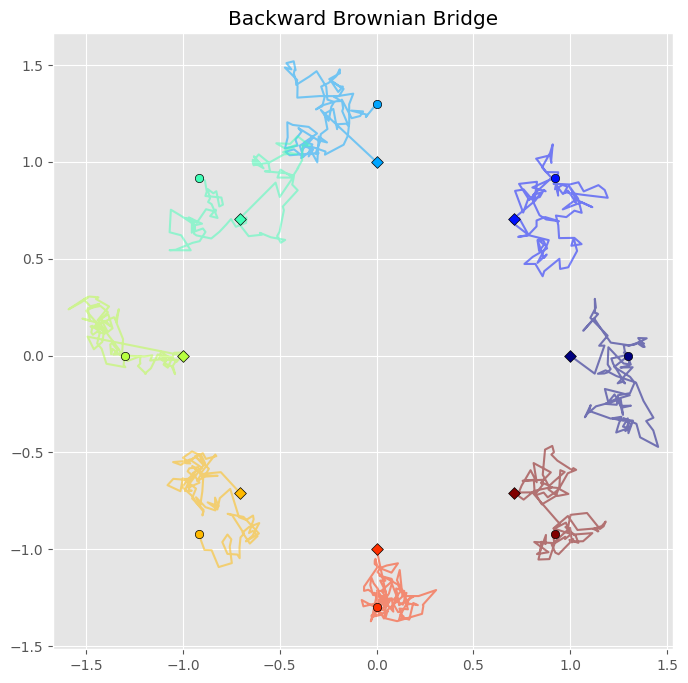

In [13]:
plot_single_trajectory(backward_brownian_bridge["trajectories"][1], title="Backward Brownian Bridge")

In [14]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 256,
                "encoding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 128, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 40,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng,
                                               loss_calibration=False)

Training: 100%|██████████| 40/40 [03:29<00:00,  5.25s/epoch, Epoch=40, loss=7.4610]


In [15]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0, 
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=16)

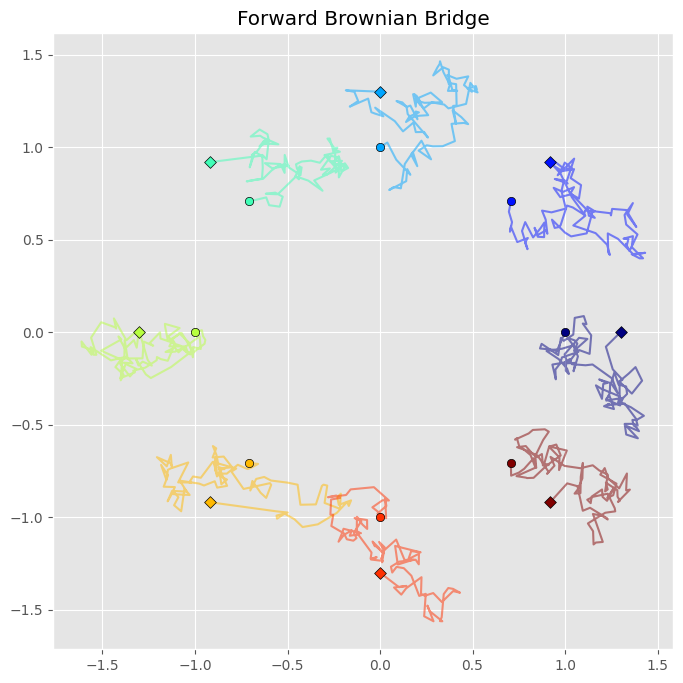

In [16]:
plot_single_trajectory(forward_brownian_bridge["trajectories"][4], title="Forward Brownian Bridge")

### Variable Q

In [25]:
alpha = 0.5
sigma = 1.0

### 2 Landmarks

In [90]:
d = 4
sde_params = {
    "dimension": d,
    "num_steps": 200,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0])
XT = jnp.array([-0.5, 3.0, 0.5, 3.0])

In [91]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=rng,
    num_batches=16
)

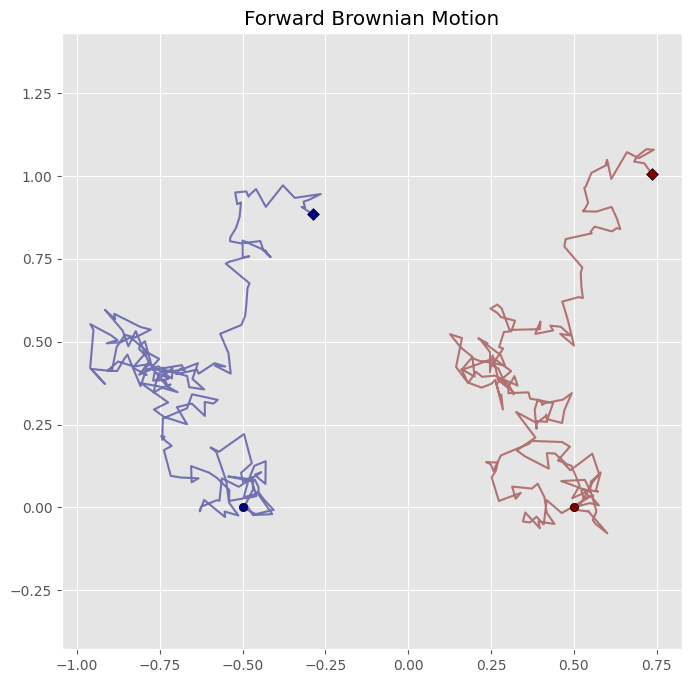

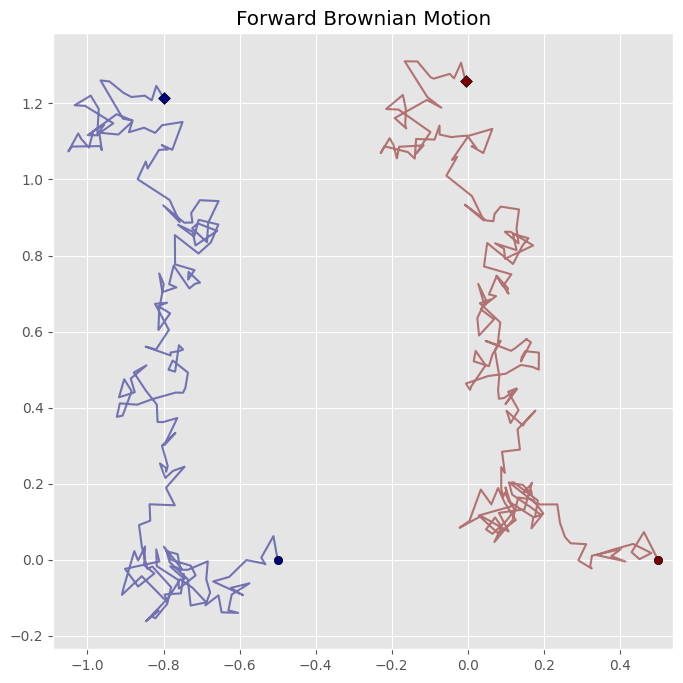

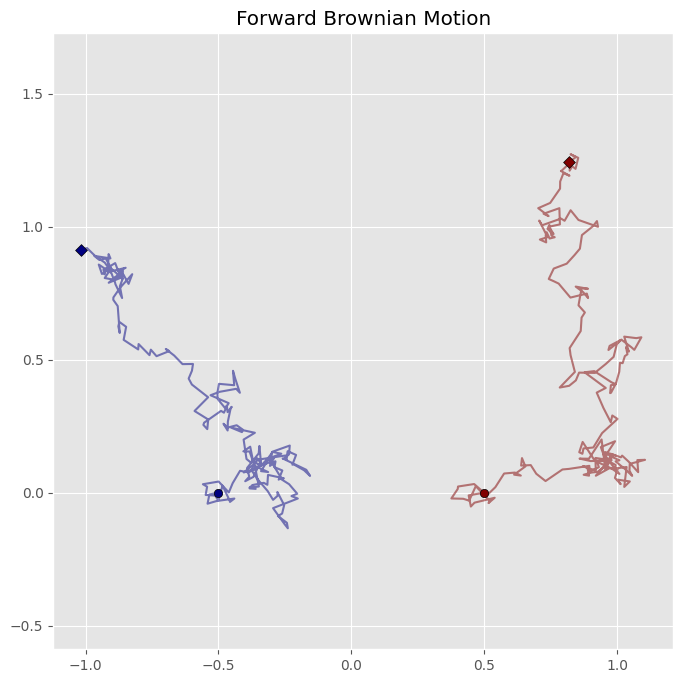

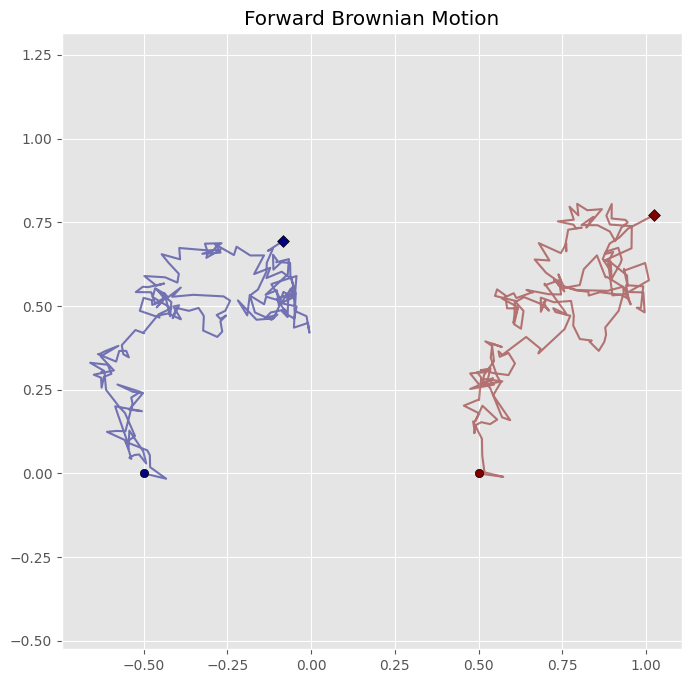

In [92]:
for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [93]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng,
                                     loss_calibration=False)

Training: 100%|██████████| 50/50 [00:46<00:00,  1.06epoch/s, Epoch=50, loss=1.9354]


In [94]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

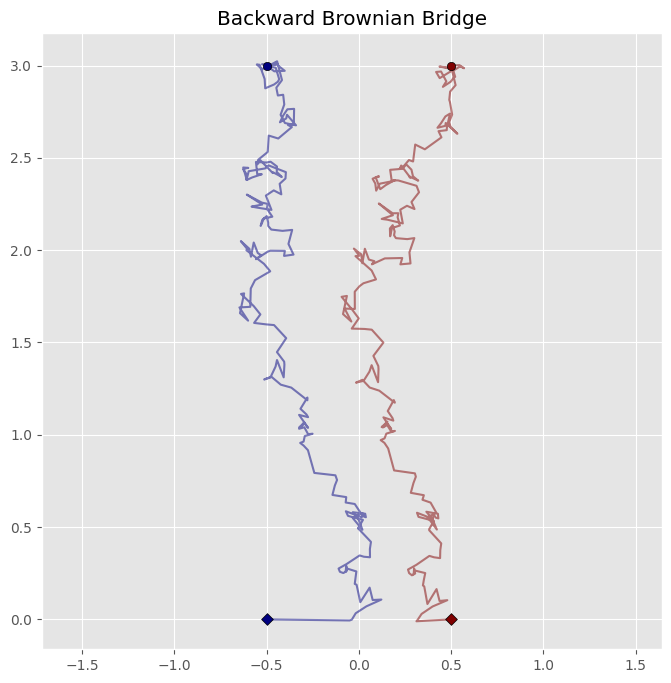

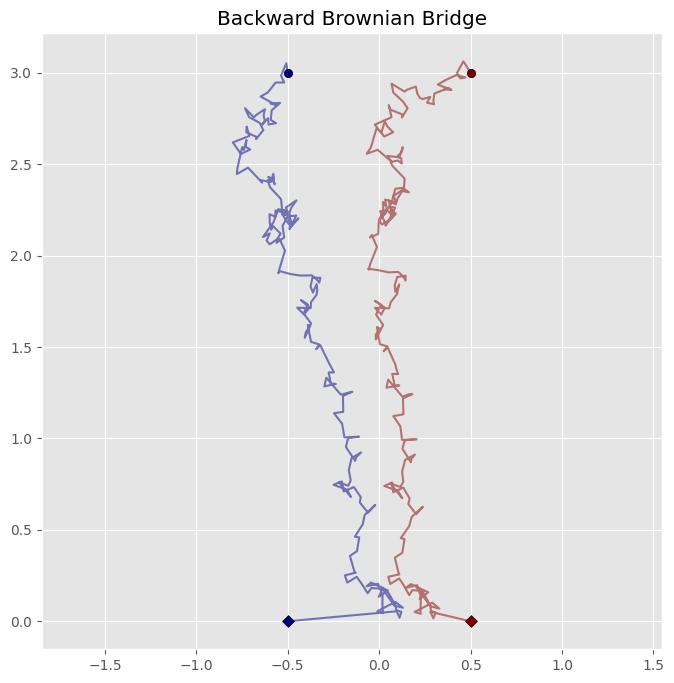

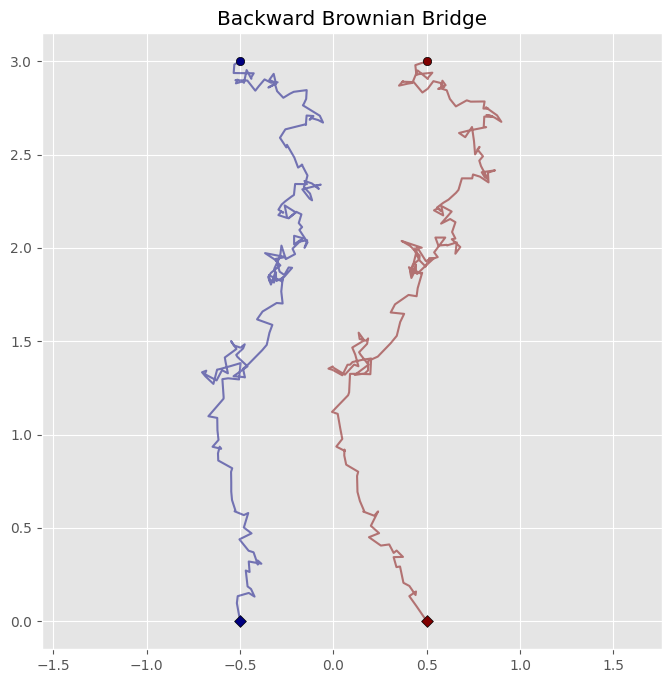

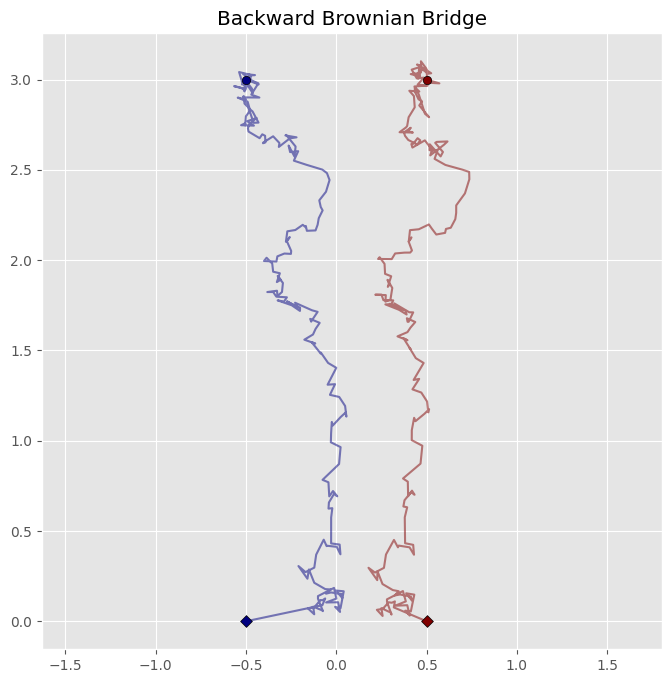

In [95]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")

In [96]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng,
                                               loss_calibration=False)

Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/epoch, Epoch=50, loss=3.2133]


In [97]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=16)

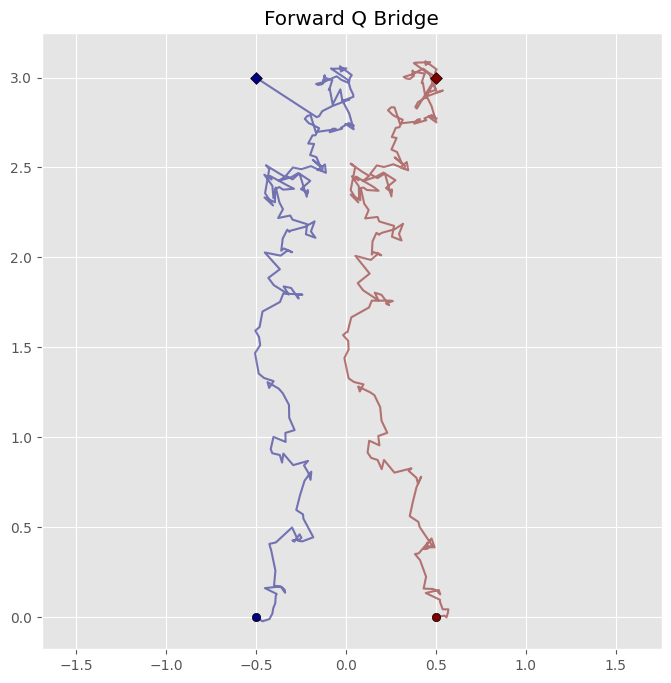

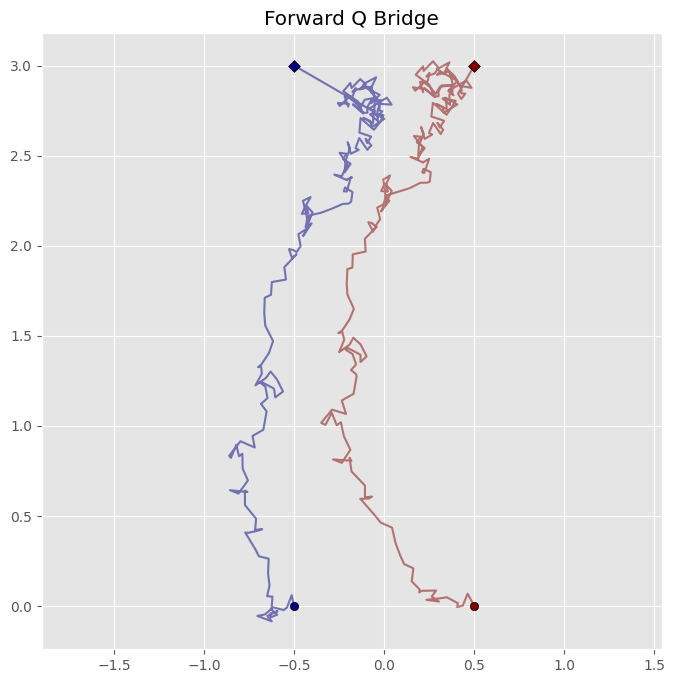

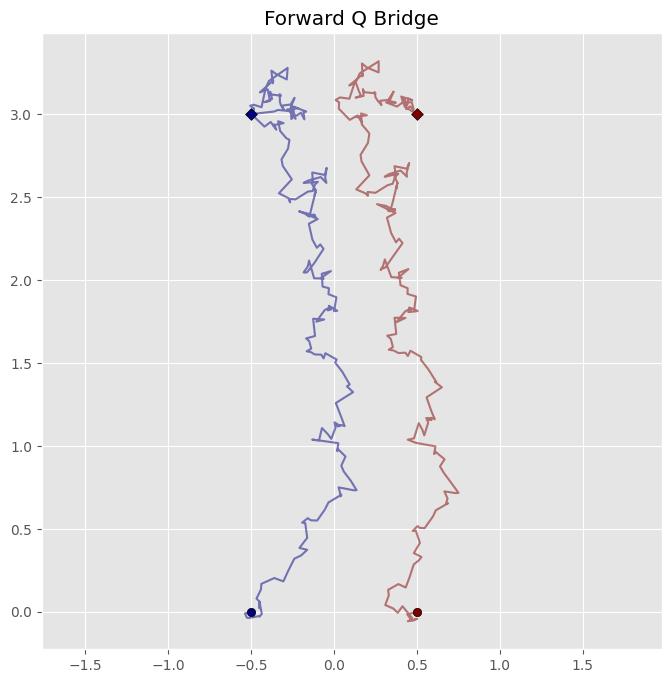

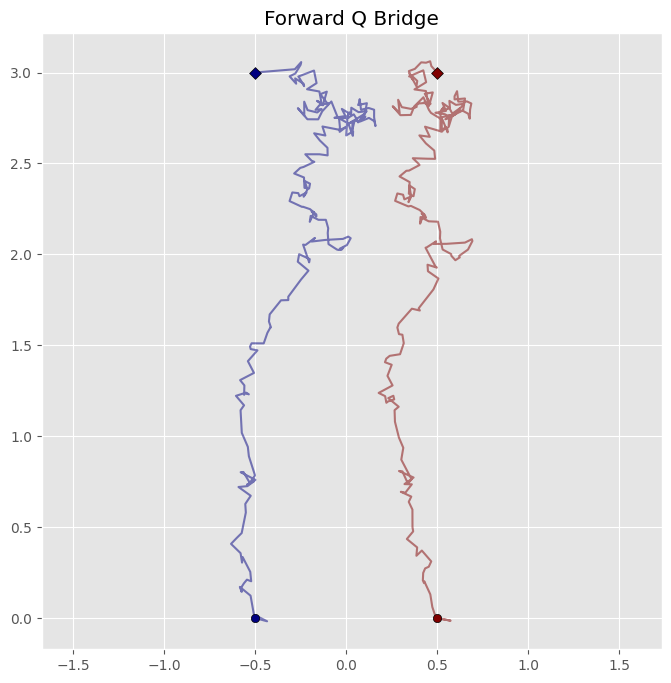

In [98]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### More Landmarks

(-1.125, 1.625, -0.7849999874830246, 1.0849999994039536)

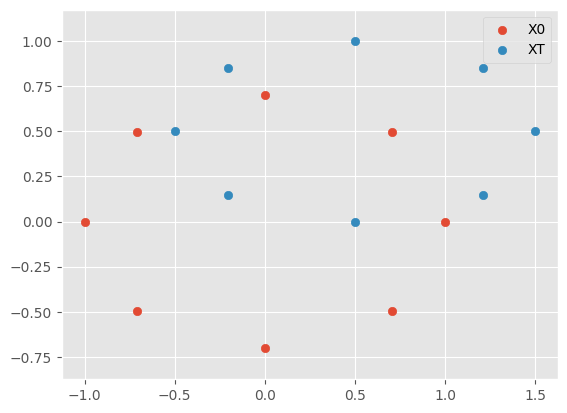

In [53]:
d = 16
X0 = sample_ellipse(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=0.7)
XT = sample_ellipse(num_points=d//2, scale=1.0, shifts=jnp.array([0.5, 0.5]), a=1.0, b=0.5)
X0_coords = X0.reshape(-1, 2)
XT_coords = XT.reshape(-1, 2)
plt.scatter(X0_coords[:, 0], X0_coords[:, 1], label="X0")
plt.scatter(XT_coords[:, 0], XT_coords[:, 1], label="XT")
plt.legend()
plt.axis('equal')

In [54]:
sde_params = {
    "dimension": d,
    "num_steps": 200,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

In [41]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=rng,
    num_batches=16
)

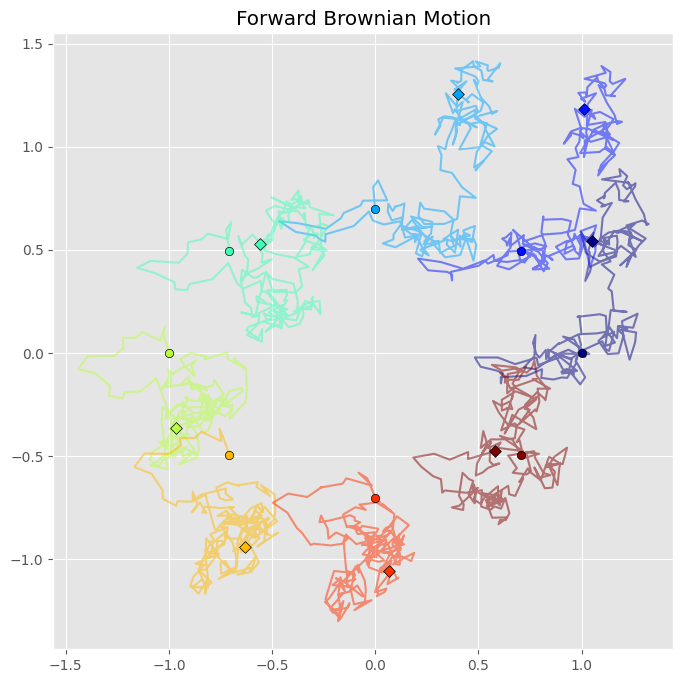

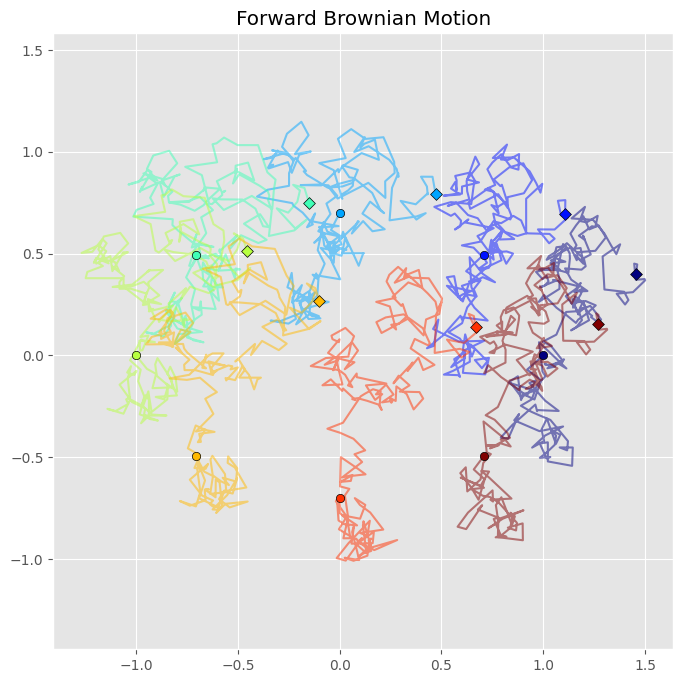

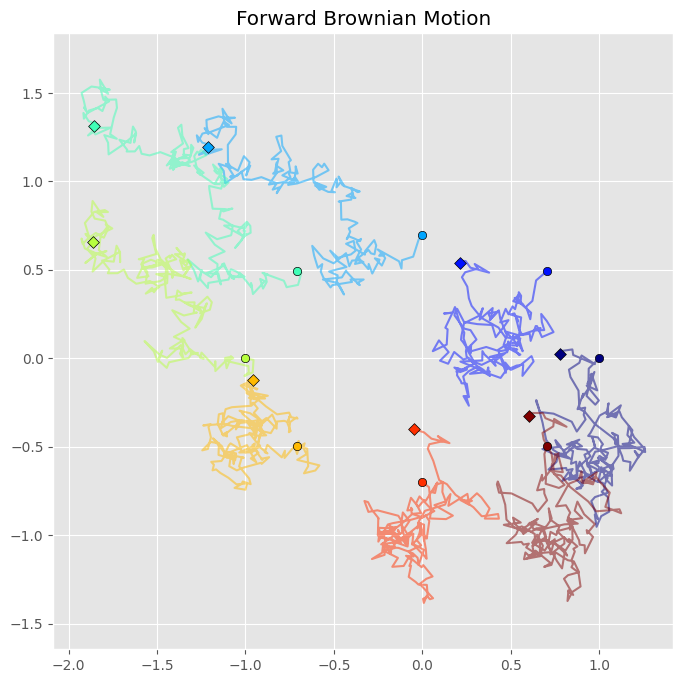

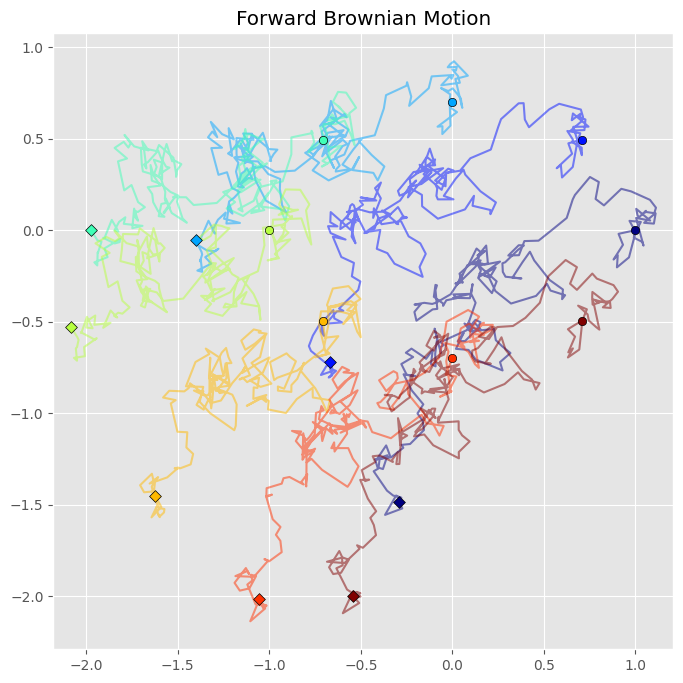

In [42]:
for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [43]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 256,
                "encoding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 128, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 40,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng,
                                     loss_calibration=False)

Training: 100%|██████████| 40/40 [02:20<00:00,  3.51s/epoch, Epoch=40, loss=10.0216]


In [44]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

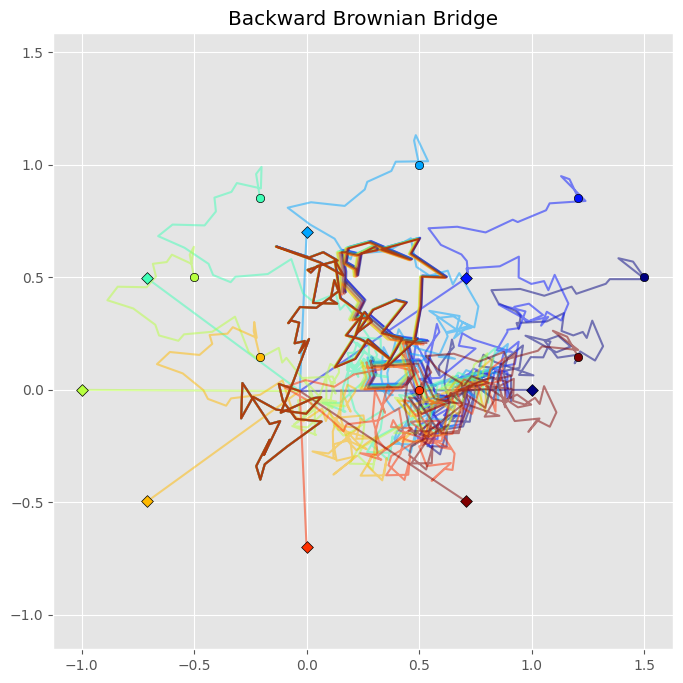

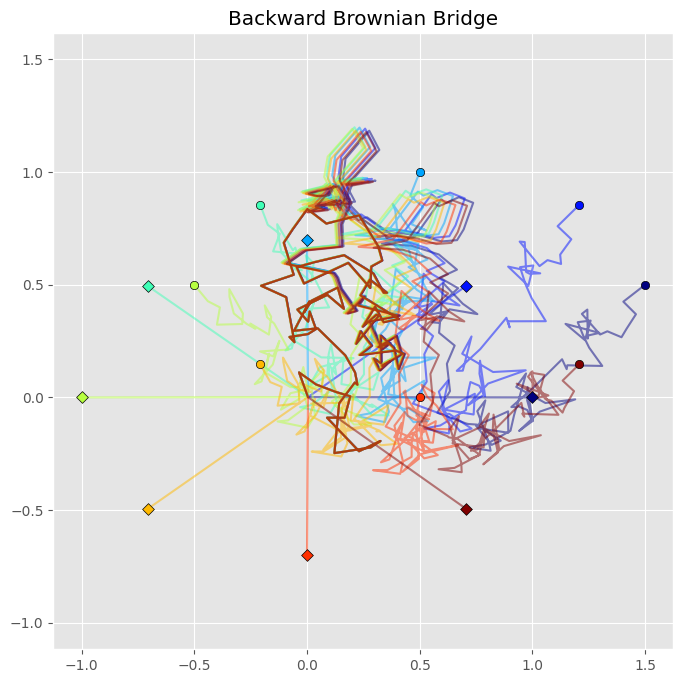

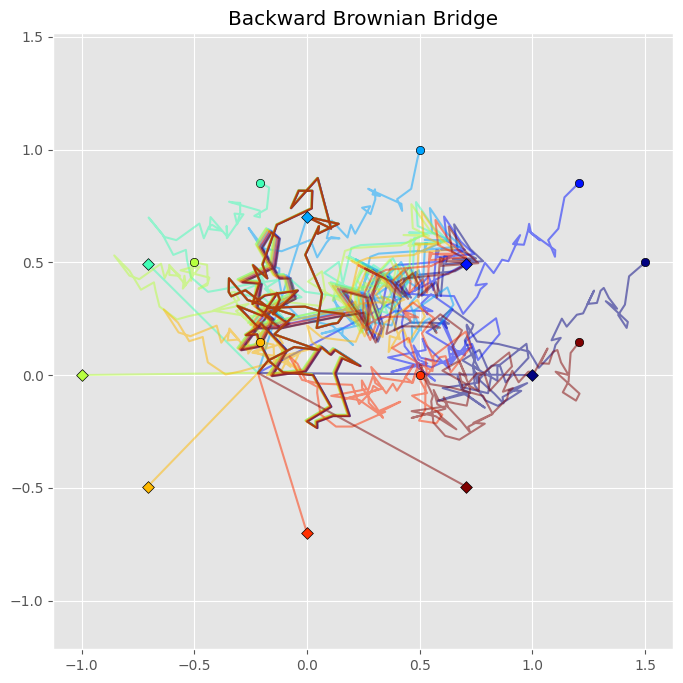

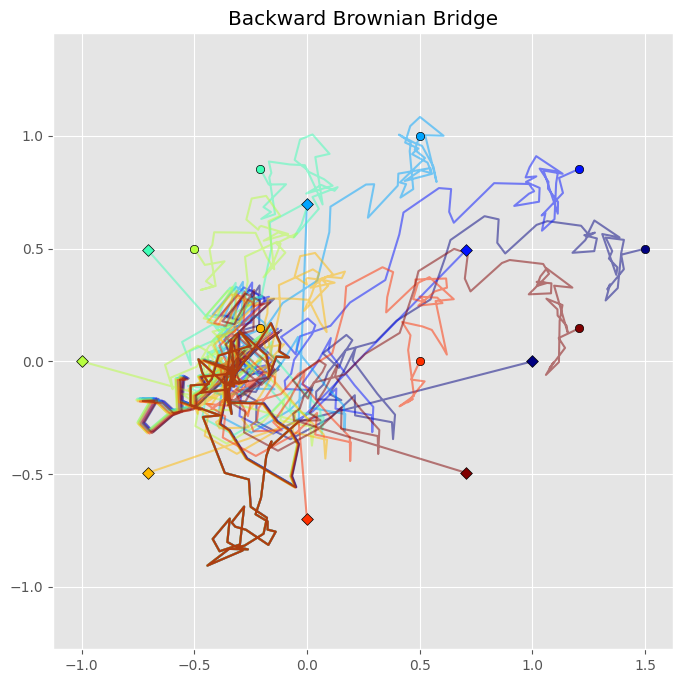

In [47]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")